# Support Vector Machine

<img src="image.png">

In [1]:
#loading Required Packages
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

## Data-Preprocessing :

1. column #1 and column #4 feature i.e x_train
2. column #14 i.e y_train , {-1,1}
3. feature scaling method used is standered normalization.
4. splitting training and testing dataset

In [3]:
# reading and preprocessing dataset
read_data = np.loadtxt("HeartDisease.csv",delimiter=',',skiprows=2)
m,n = read_data.shape
#np.random.shuffle(read_data)                 #shuffling dataset
x_data = np.ones((m,n-1))                           
x_data[:,0:n-1] = read_data[:,0:n-1]            #column1
#x_data[:,1:2] = read_data[:,3:4]            #column4
y_data = read_data[:,-1:]                   
y_data[y_data==0] = -1                      # y = {-1,1} column14

#x_data = (x_data-np.mean(x_data,axis=0))/np.std(x_data,axis=0)        #feature scaling(standered)

              
k = int(0.7*m)                              #splitting dataset
x_train = x_data[:k,:]
y_train = y_data[:k,:]
x_test  = x_data[k:,:]
y_test  = y_data[k:,:]

print("Training -> 70% , Testing 30%")
print("Training data-set shape->",x_train.shape, y_train.shape)
print("Testing  data-set shape->",x_test.shape, y_train.shape)

Training -> 70% , Testing 30%
Training data-set shape-> (212, 13) (212, 1)
Testing  data-set shape-> (91, 13) (212, 1)


## Plotting our training Data-set

Blue -> +1
Red  -> -1


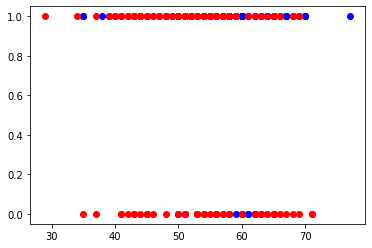

In [4]:
pos = []
neg = []
for i in range(x_train.shape[0]):
    if y_data[i]==1:
        pos.append(x_train[i])
    else:
        neg.append(x_train[i])
pos = np.array(pos)
neg = np.array(neg)
plt.scatter(pos[:,0],pos[:,1],color='blue')
plt.scatter(neg[:,0],neg[:,1],color='red')
print("Blue -> +1")
print("Red  -> -1")

## RBF kernel :
\begin{equation}
K(x,z) = exp(-\frac{|| x - z ||^2}{2 \sigma^2})
\end{equation}

In [6]:
#defining kernel
def rbf_kernel(x1, x2, sigma=1):
    return np.exp(- (np.linalg.norm(x1 - x2, 2)) ** 2 / (2 * sigma ** 2))

### Defining basic functions required to for SMO Algorithm :

In [7]:
#function to predict when we have x,w,b
def predict(x,w,b):
    return h(x,w,b)

#function to calculate bias
def calc_b(x, y, w):
    b_tmp = y - np.dot(w.T, x.T)
    return np.mean(b_tmp)

#function to calculate weight
def calc_w(alpha, y, x):
    return np.dot(x.T, np.multiply(alpha,y))
    
def h(x, w, b):
    return np.sign(np.dot(w.T, x.T) + b).astype(int)
    
def E(x_k, y_k, w, b):
    return h(x_k, w, b) - y_k

#performing clipping operation
def compute_L_H(C, alpha_prime_j, alpha_prime_i, y_j, y_i):
    if(y_i != y_j):
        return (max(0,alpha_prime_j-alpha_prime_i), min(C, C-alpha_prime_i+alpha_prime_j))
    else:
        return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
        

#generate random Int number between a to b , but not z
def getRndInt(a,b,z):
    i = z
    cnt=0
    while i == z and cnt<1000:
        i = rnd.randint(a,b)
        cnt=cnt+1
    return i
       



### function to compute accuracy for using test data:

In [8]:
def cal_accuray(x_test,y_test,w,b):
    y_predicted = [predict(x,w,b) for x in x_test]
    count=0
    for i in range(len(y_predicted)):
        if y_predicted[i]==y_test[i]:
            count += 1
    return count/len(y_predicted)


## SMO algorithm :

In [9]:
def trainSMO(x_train, y_train,kernel,C=1.0,epsilon=0.001,max_iter=100):
    n, d = x_train.shape[0], x_train.shape[1]
    alpha = np.zeros((n))
    kernel = rbf_kernel
    count = 0
    while True:
        count += 1
        lst_alpha = np.copy(alpha)
            
        for j in range(0, n):
            #two alpha for are selected randomly for SMO Algorithm for that j for is selected and i is selected randomly
            i = getRndInt(0, n-1, j)
            x_i, x_j, y_i, y_j = x_train[i,:], x_train[j,:], y_train[i], y_train[j] 
            k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
            if k_ij == 0:
                continue
                    
            #two alpha's are selected let say aj^, ai^ and L,H computed to apply clipping of alpha between [L,H]        
            alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]        #
            (L, H) = compute_L_H(C, alpha_prime_j, alpha_prime_i, y_j, y_i)

            # calculate weight,bias 
            w = calc_w(alpha, y_train, x_train)
            b = calc_b(x_train, y_train, w)

            # Compute E_i, E_j
            E_i = E(x_i, y_i, w, b)
            E_j = E(x_j, y_j, w, b)

            # Updating one of the alpha values
            alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
            alpha[j] = max(alpha[j], L)
            alpha[j] = min(alpha[j], H)
            
            #computing other alpha using pervios alpha computed above
            alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

        diff = np.linalg.norm(alpha - lst_alpha)
        if diff < epsilon:
            break
        
        if count >= max_iter:
            print("Iteration Exceeds than",max_iter)
            return
    
    w = calc_w(alpha, y_train, x_train)
    b = calc_b(x_train, y_train, w)

    return w,b

### Testing our Algorithm :

In [11]:
w,b=trainSMO(x_train, y_train.flatten(),rbf_kernel,C=1.0,epsilon=0.001,max_iter=100)
print("Accuracy ->",cal_accuray(x_test,y_test,w,b))

print("Actual     ->",y_test[0])
print("Predicted ->",predict(x_test[0],w,b))


Accuracy -> 0.7032967032967034
Actual     -> [-1.]
Predicted -> -1


## C vs Accuracy

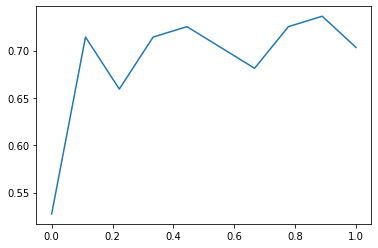

In [12]:
c = np.linspace(0,1,10)
acc = []
for k in c:
    w,b=trainSMO(x_train, y_train.flatten(),rbf_kernel,C=k,epsilon=0.001,max_iter=100)
    acc.append(cal_accuray(x_test,y_test,w,b))

plt.plot(c,acc)

## Epsilon vs Accuracy :

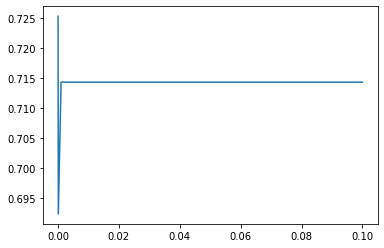

In [13]:
epsilon = [0.1,0.01,0.001,0.0001,0.00001]
acc = []
for k in epsilon:
    w,b=trainSMO(x_train, y_train.flatten(),rbf_kernel,C=1.0,epsilon=k,max_iter=100)
    acc.append(cal_accuray(x_test,y_test,w,b))
plt.plot(epsilon,acc)

## Iteration vs Accuracy :

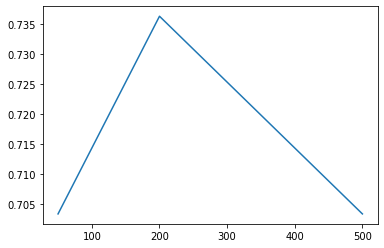

In [14]:
iterations = [50,100,200,500]
acc = []
for it in iterations:
    w,b=trainSMO(x_train, y_train.flatten(),rbf_kernel,C=1.0,epsilon=0.001,max_iter=it)
    acc.append(cal_accuray(x_test,y_test,w,b))

plt.plot(iterations,acc)

## Results :
<ul>
    <li>Accuracy for our data-set between 55%-60% </li>
    
</ul>

## Analysis:
<ul>
    <li>Best value for C=1.0 where algorithm have given maximum Accuracy</li>
    <li>Best value for epsilon is 0.01 from the plot</li>
    <li>Best value for max_iteration for our data-set is 200</li>
</ul>

Observations :
<ul>
    <li>Given Data-set in not classifiable from the plot</li>
    <li>for this Data-set of data-set linear kernel is not suitable </li>
    
</ul>